<a href="https://colab.research.google.com/github/samitha278/gpt2-lite/blob/main/optimize_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import gdown
import time
import matplotlib.pyplot as plt

import tiktoken

from dataclasses import dataclass


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Data file doenload

file_id = "1ia6z4itw7WJWpnoTohURX6Lm-AnZmVZz"
url = f"https://drive.google.com/uc?id={file_id}"

output = "input.txt"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ia6z4itw7WJWpnoTohURX6Lm-AnZmVZz
To: /content/input.txt
100%|██████████| 1.12M/1.12M [00:00<00:00, 12.0MB/s]


'input.txt'

# GPT-2 Model

In [3]:
@dataclass
class GPT2Config:
    block_size : int = 1024
    vocab_size : int = 50257
    n_layer : int = 12
    n_head : int = 12
    n_embd : int = 768


# ----------------------------------------------------------------------------------


class GPT2(nn.Module):

    def __init__(self,config):
        super().__init__()

        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.n_embd),
            wpe = nn.Embedding(config.block_size,config.n_embd),

            h = nn.ModuleList([Block(config) for i in range(config.n_layer)]),

            ln_f = nn.LayerNorm(config.n_embd),

        ))

        self.lm_head = nn.Linear(config.n_embd,config.vocab_size, bias=False)


        #weight sharing
        self.transformer.wte.weight = self.lm_head.weight
        #Save ~38M parameters

        self.apply(self._init_weights)



    def _init_weights(self,module):

        if isinstance(module,nn.Linear):
            std = 0.02
            if hasattr(module,'FLAG'):
                std *= (2*self.config.n_layer) ** -0.5           #scaledown std
            torch.nn.init.normal_(module.weight,mean=0.0,std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module,nn.Embedding):
            torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)



    def forward(self,x,targets= None):

        B,T = x.shape
        assert T<= self.config.block_size   # positional embd table max size = block_size
        tx = self.transformer.wte(x)       #token embedding
        px = self.transformer.wpe(torch.arange(0,T,self.config.block_size,device=device)) #positional embedding

        x = tx+px     # add both

        for block in self.transformer.h:
          x = block(x)

        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(B*T,-1) ,targets.view(-1))
            return logits,loss



    @classmethod
    def from_pretrained(cls, model_type='gpt2'):
        from transformers import GPT2LMHeadModel
        assert model_type == 'gpt2'

        config_args = dict(n_layer=12, n_head=12, n_embd=768, vocab_size=50257, block_size=1024)
        config = GPT2Config(**config_args)
        model = GPT2(config)

        sd = model.state_dict()
        sd_keys = [k for k in sd.keys() if not k.endswith('.attn.bias')]

        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        sd_keys_hf = [k for k in sd_hf.keys() if not k.endswith(('.attn.masked_bias', '.attn.bias'))]

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(sd_keys_hf) == len(sd_keys)

        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


# ----------------------------------------------------------------------------------



class Block(nn.Module):

    def __init__(self,config):
        super().__init__()
        self.config = config

        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)


    def forward(self,x):

        x = self.attn(self.ln_1(x)) + x
        x = self.mlp(self.ln_2(x)) + x

        return x



# ----------------------------------------------------------------------------------


class MLP(nn.Module):

    def __init__(self,config):
        super().__init__()
        self.config = config

        self.c_fc = nn.Linear(config.n_embd,4*config.n_embd)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4*config.n_embd,config.n_embd)
        self.c_proj.FLAG = 1


    def forward(self,x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)

        return x

# ----------------------------------------------------------------------------------

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()

        block_size = config.block_size

        self.n_head = n_head = config.n_head
        self.n_embd = n_embd = config.n_embd


        assert n_embd % n_head == 0
        self.head_size = n_embd // n_head

        self.c_attn = nn.Linear(n_embd, 3 * n_embd)     # fan out : n_head * 3 * head_size

        self.c_proj = nn.Linear(n_embd, n_embd)

        self.c_proj.FLAG = 1

        self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size)))



    def forward(self, x):
        B, T, C = x.size()  # C = n_embd = n_head * head_size

        qkv = self.c_attn(x)    # B,T, 3*n_embd

        q, k, v = qkv.split(self.n_embd, dim=2)    # each : B,T, n_head * head_size

        k = k.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # B, n_head, T, head_size
        q = q.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # ""
        v = v.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # ""

        att = (q @ k.transpose(-2, -1)) * (self.head_size**-0.5)         # B, n_head, T, T
        att = att.masked_fill(self.bias[:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        y = att @ v        # B, n_head, T, head_size
        y = y.transpose(1, 2).contiguous().view(B, T, C)   # B, T , n_embd   (n_embd = n_head * head_size)

        y = self.c_proj(y)
        return y





# ----------------------------------------------------------------------------------

class DataLoader():

  def __init__(self,B,T):

    self.B = B
    self.T = T

    with open('input.txt', 'r') as f:
      text = f.read()

    enc = tiktoken.get_encoding('gpt2')
    self.tokens = torch.tensor(enc.encode(text))

    print(f'1 epoch size: {len(self.tokens//B*T)}')

    self.count = 0



  def get_batch(self):

    B,T = self.B , self.T

    temp = self.tokens[self.count:self.count+B*T+1]

    x = temp[:-1].view(B,T)   #inputs
    y = temp[1:].view(B,T)    #targets

    self.count += B*T

    # Reset
    if (self.count+B*T+1) > len(self.tokens):
      self.count = 0

    return x,y


## Automatic Mixed Precision (AMP)
PyTorch automatically picks the best precision (FP32, FP16, BF16) for each operation.

In [6]:
max_iter = 100
lr = 3e-4
B = 4
T = 1024


torch.manual_seed(278)
if torch.cuda.is_available():
  torch.cuda.manual_seed(278)


model = GPT2(GPT2Config())
model = model.to(device)


data = DataLoader(B,T)

optimizer = torch.optim.AdamW(model.parameters(),lr = lr)

losses = torch.zeros((max_iter,))

#optimize
for i in range(max_iter):

  t0 = time.time()   # time start

  xb , yb = data.get_batch()
  xb , yb = xb.to(device),yb.to(device)

  #AMP
  with torch.autocast(device_type=device, dtype=torch.bfloat16):
    logits , loss = model(xb,yb)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  torch.cuda.synchronize()   # cpu and cuda sync

  t1 = time.time()   # time end

  t = (t1 - t0)*1000   # ms

  losses[i] = loss.item()

  if i%10==0 : print(f'{i}/{max_iter}   {loss.item()}    {t} ms')

1 epoch size: 338025
0/100   10.93682861328125    1616.471767425537 ms
10/100   7.506147384643555    1478.6090850830078 ms
20/100   7.094169616699219    1495.218276977539 ms
30/100   6.7423095703125    1506.7317485809326 ms
40/100   6.604820251464844    1517.301082611084 ms
50/100   6.578647613525391    1528.116226196289 ms
60/100   6.569816589355469    1536.2906455993652 ms
70/100   6.435047149658203    1549.015998840332 ms
80/100   6.783174514770508    1558.340072631836 ms
90/100   6.256216049194336    1558.7353706359863 ms


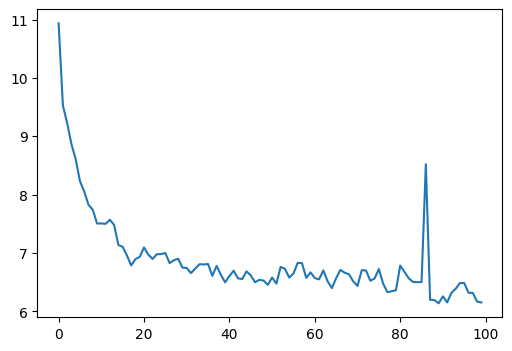

In [7]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

### T4 GPU doesn't support BF16

# FP16 Training & Gradient Scaling

### Problem
- In **FP16** Training, gradients can be very small.  
- They may round to zero (**underflow**) → training becomes unstable.  

### Solution → Gradient Scaling
- Multiply loss by a **scale factor** before backprop.  
- Makes gradients bigger → avoids underflow.  
- Scale back down before optimizer step.  

### `torch.cuda.amp.GradScaler()`
- Prevents underflow in FP16.  
- Adjusts scale automatically.  
- Used with `torch.autocast` for mixed precision training.  


In [4]:
max_iter = 100
lr = 3e-4
B = 4
T = 1024


torch.manual_seed(278)
if torch.cuda.is_available():
  torch.cuda.manual_seed(278)


model = GPT2(GPT2Config())
model = model.to(device)



data = DataLoader(B,T)
optimizer = torch.optim.AdamW(model.parameters(),lr = lr)
losses = torch.zeros((max_iter,))


#Gradient Scalar
scaler = torch.amp.GradScaler(device)     # Prevents gradient underflow when using FP16



#optimize
for i in range(max_iter):

  t0 = time.time()   # time start

  xb , yb = data.get_batch()
  xb , yb = xb.to(device),yb.to(device)

  #AMP
  with torch.autocast(device_type=device, dtype=torch.float16):   # FP16
    logits , loss = model(xb,yb)

  optimizer.zero_grad()

  scaler.scale(loss).backward()     # multiplies loss by a scale factor
  scaler.step(optimizer)            # unscales gradients then call optimizer step
  scaler.update()                   # adjusts the scale factor automatically each iteration


  torch.cuda.synchronize()

  t1 = time.time()   # time end
  t = (t1 - t0)*1000 # ms

  losses[i] = loss.item()

  if i%10==0 : print(f'{i}/{max_iter}   {loss.item()}    {t} ms')

1 epoch size: 338025


/tmp/ipython-input-2856615254.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()     # Prevents gradient underflow when using FP16


0/100   10.936931610107422    2727.642774581909 ms
10/100   7.506355285644531    457.3230743408203 ms
20/100   7.090892314910889    461.38930320739746 ms
30/100   6.739969253540039    458.10413360595703 ms
40/100   6.603733062744141    461.1625671386719 ms
50/100   6.583924770355225    461.41934394836426 ms
60/100   6.57258939743042    465.5015468597412 ms
70/100   6.435788631439209    466.77279472351074 ms
80/100   6.785599708557129    464.48493003845215 ms
90/100   6.31415319442749    465.05022048950195 ms


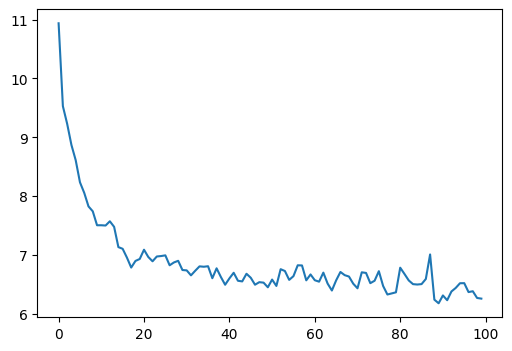

In [5]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

# With Torch Compile

In [7]:
max_iter = 1000
lr = 3e-4
B = 4
T = 1024


torch.manual_seed(278)
if torch.cuda.is_available():
  torch.cuda.manual_seed(278)


model = GPT2(GPT2Config())
model = model.to(device)
model = torch.compile(model)    # compile model into optimize form



data = DataLoader(B,T)
optimizer = torch.optim.AdamW(model.parameters(),lr = lr)
losses = torch.zeros((max_iter,))


#Gradient Scalar
scaler = torch.amp.GradScaler(device)     # Prevents gradient underflow when using FP16



#optimize
for i in range(max_iter):

  t0 = time.time()   # time start

  xb , yb = data.get_batch()
  xb , yb = xb.to(device),yb.to(device)

  #AMP
  with torch.autocast(device_type=device, dtype=torch.float16):   # FP16
    logits , loss = model(xb,yb)

  optimizer.zero_grad()

  scaler.scale(loss).backward()     # multiplies loss by a scale factor
  scaler.step(optimizer)            # unscales gradients then call optimizer step
  scaler.update()                   # adjusts the scale factor automatically each iteration


  torch.cuda.synchronize()

  t1 = time.time()   # time end
  t = (t1 - t0)*1000 # ms

  losses[i] = loss.item()

  if i%100==0 : print(f'{i}/{max_iter}   {loss.item()}    {t} ms')

1 epoch size: 338025
0/1000   10.936920166015625    351.55177116394043 ms
100/1000   6.479531288146973    311.5057945251465 ms
200/1000   6.402681350708008    304.485559463501 ms
300/1000   6.378115653991699    304.52775955200195 ms
400/1000   6.456864356994629    305.42635917663574 ms
500/1000   6.316775321960449    304.31127548217773 ms
600/1000   6.322683334350586    312.0260238647461 ms
700/1000   6.105173110961914    310.18543243408203 ms
800/1000   5.920889377593994    313.4734630584717 ms
900/1000   6.097590446472168    309.53264236450195 ms


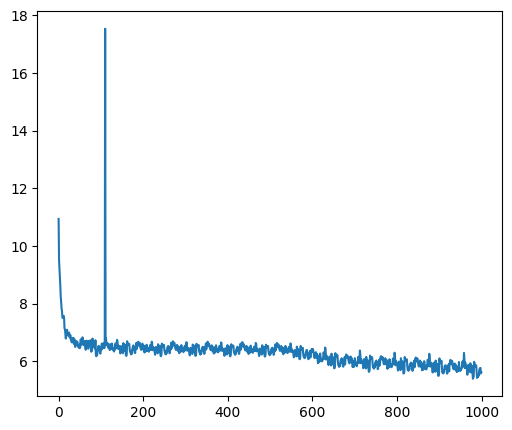

In [11]:
plt.figure(figsize=(6,5))
plt.plot(losses)
plt.show()

- Sudden spike is normal in FP16 Training with GradScaler
- Reason : Gradient Overflow
- GradScaler skips that optimizer step -> lowers the scale factor
- Loss on that skipped step looks much higher
- Training continues normally with the smaller scale

# Flash Attention

Next optimize2_gpt2.ipynb